In [147]:
import os,sys
import numpy as np
from prepare_adult_data import *
sys.path.insert(0, '../../fair_classification/') # the code for fair classification is in this directory
import utils as ut
import loss_funcs as lf # loss funcs that can be optimized subject to various constraints

import matplotlib.pyplot as plt

In [47]:
def load_adult_data(load_data_size=None): #Ne marche pas quand on l'importe alors qu'elle est identique...

    """
        if load_data_size is set to None (or if no argument is provided), then we load and return the whole data
        if it is a number, say 10000, then we will return randomly selected 10K examples
    """
    attrs = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country'] # all attributes
    int_attrs = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week'] # attributes with integer values -- the rest are categorical
    sensitive_attrs = ['sex', 'race'] # the fairness constraints will be used for this feature
    attrs_to_ignore = ['sex', 'race' ,'fnlwgt'] # sex and race are sensitive feature so we will not use them in classification, we will not consider fnlwght for classification since its computed externally and it highly predictive for the class (for details, see documentation of the adult data)
    attrs_for_classification = set(attrs) - set(attrs_to_ignore)

    # adult data comes in two different files, one for training and one for testing, however, we will combine data from both the files
    data_files = ["adult.data", "adult.test"]



    X = []
    y = []
    x_control = {}

    attrs_to_vals = {} # will store the values for each attribute for all users
    for k in attrs:
        if k in sensitive_attrs:
            x_control[k] = []
        elif k in attrs_to_ignore:
            pass
        else:
            attrs_to_vals[k] = []

    for f in data_files:
        check_data_file(f)

        for line in open(f):
            line = line.strip()
            if line == "": continue # skip empty lines
            line = line.split(", ")
            if len(line) != 15 or "?" in line: # if a line has missing attributes, ignore it
                continue

            class_label = line[-1]
            if class_label in ["<=50K.", "<=50K"]:
                class_label = -1
            elif class_label in [">50K.", ">50K"]:
                class_label = +1
            else:
                raise Exception("Invalid class label value")

            y.append(class_label)


            for i in range(0,len(line)-1):
                attr_name = attrs[i]
                attr_val = line[i]
                # reducing dimensionality of some very sparse features
                if attr_name == "native_country":
                    if attr_val!="United-States":
                        attr_val = "Non-United-Stated"
                elif attr_name == "education":
                    if attr_val in ["Preschool", "1st-4th", "5th-6th", "7th-8th"]:
                        attr_val = "prim-middle-school"
                    elif attr_val in ["9th", "10th", "11th", "12th"]:
                        attr_val = "high-school"

                if attr_name in sensitive_attrs:
                    x_control[attr_name].append(attr_val)
                elif attr_name in attrs_to_ignore:
                    pass
                else:
                    attrs_to_vals[attr_name].append(attr_val)

    def convert_attrs_to_ints(d): # discretize the string attributes
        for attr_name, attr_vals in d.items():
            if attr_name in int_attrs: continue
            uniq_vals = sorted(list(set(attr_vals))) # get unique values

            # compute integer codes for the unique values
            val_dict = {}
            for i in range(0,len(uniq_vals)):
                val_dict[uniq_vals[i]] = i

            # replace the values with their integer encoding
            for i in range(0,len(attr_vals)):
                attr_vals[i] = val_dict[attr_vals[i]]
            d[attr_name] = attr_vals

    
    # convert the discrete values to their integer representations
    convert_attrs_to_ints(x_control)
    convert_attrs_to_ints(attrs_to_vals)


    # if the integer vals are not binary, we need to get one-hot encoding for them
    for attr_name in attrs_for_classification:
        attr_vals = attrs_to_vals[attr_name]
        if attr_name in int_attrs or attr_name == "native_country": # the way we encoded native country, its binary now so no need to apply one hot encoding on it
            X.append(attr_vals)

        else:            
            attr_vals, index_dict = ut.get_one_hot_encoding(attr_vals)
            for inner_col in attr_vals.T:                
                X.append(inner_col) 


    # convert to numpy arrays for easy handline
    X = np.array(X, dtype=float).T
    y = np.array(y, dtype = float)
    for k, v in x_control.items(): x_control[k] = np.array(v, dtype=float)
        
    # shuffle the data
    perm = list(range(0,len(y))) # shuffle the data before creating each fold
    shuffle(perm)
    X = X[perm]
    y = y[perm]
    for k in x_control.keys():
        x_control[k] = x_control[k][perm]

    # see if we need to subsample the data
    if load_data_size is not None:
        print("Loading only %d examples from the data" % load_data_size)
        X = X[:load_data_size]
        y = y[:load_data_size]
        for k in x_control.keys():
            x_control[k] = x_control[k][:load_data_size]

    return X, y, x_control

In [53]:
def compute_p_rule(x_control, class_labels, sensitive_attr):

    """ Compute the p-rule based on Doctrine of disparate impact """

    if sensitive_attr=="sex":
        non_prot_all = sum(x_control == 1.0) # non-protected group
        prot_all = sum(x_control == 0.0) # protected group
        non_prot_pos = sum(class_labels[x_control == 1.0] == 1.0) # non_protected in positive class
        prot_pos = sum(class_labels[x_control == 0.0] == 1.0) # protected in positive class
    elif sensitive_attr=="race":
        non_prot_all = sum(x_control == 4.0) # non-protected group
        prot_all = sum(x_control != 4.0) # protected group
        non_prot_pos = sum(class_labels[x_control == 4.0] == 1.0) # non_protected in positive class
        prot_pos = sum(class_labels[x_control != 4.0] == 1.0) # protected in positive class
    frac_non_prot_pos = float(non_prot_pos) / float(non_prot_all)
    frac_prot_pos = float(prot_pos) / float(prot_all)
    p_rule = (frac_prot_pos / frac_non_prot_pos) * 100.0
    print
    print("Total data points: %d" % (len(x_control)))
    print("# non-protected examples: %d" % (non_prot_all))
    print("# protected examples: %d" % (prot_all))
    print("Non-protected in positive class: %d (%0.0f%%)" % (non_prot_pos, non_prot_pos * 100.0 / non_prot_all))
    print("Protected in positive class: %d (%0.0f%%)" % (prot_pos, prot_pos * 100.0 / prot_all))
    print("P-rule is: %0.0f%%" % ( p_rule ))
    return p_rule

In [59]:
""" Load the adult data """
X, y, x_control = load_adult_data(load_data_size=10000) # set the argument to none, or no arguments if you want to test with the whole data -- we are subsampling for performance speedup
print("\n\"sex\" sentitive attribute :\n")
compute_p_rule(x_control["sex"], y, "sex") # compute the p-rule in the original data for the sensitive attribute sex
print("\n\"race\" sentitive attribute :\n")
compute_p_rule(x_control["race"], y, "race") # compute the p-rule in the original data for the sensitive attribute race

Looking for file 'adult.data' in the current directory...
File found in current directory..
Looking for file 'adult.test' in the current directory...
File found in current directory..
Loading only 10000 examples from the data

"sex" sentitive attribute :

Total data points: 10000
# non-protected examples: 6743
# protected examples: 3257
Non-protected in positive class: 2077 (31%)
Protected in positive class: 353 (11%)
P-rule is: 35%

"race" sentitive attribute :

Total data points: 10000
# non-protected examples: 8611
# protected examples: 1389
Non-protected in positive class: 2204 (26%)
Protected in positive class: 226 (16%)
P-rule is: 64%


63.56941172473897

In [60]:
""" Split the data into train and test """
X = ut.add_intercept(X) # add intercept to X before applying the linear classifier (so that the boundary hyperplan in defined as theta^T*X=0)
train_fold_size = 0.7
x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

In [105]:
apply_fairness_constraints = None
apply_accuracy_constraint = None
sep_constraint = None

loss_function = lf._logistic_loss
sensitive_attrs = ['sex', 'race']
sensitive_attrs_to_cov_thresh = {}
gamma = None

In [79]:
def train_test_classifier():
    w = ut.train_model(x_train, y_train, x_control_train, loss_function, apply_fairness_constraints, apply_accuracy_constraint, sep_constraint, sensitive_attrs, sensitive_attrs_to_cov_thresh, gamma)
    train_score, test_score, correct_answers_train, correct_answers_test = ut.check_accuracy(w, x_train, y_train, x_test, y_test, None, None)
    distances_boundary_test = (np.dot(x_test, w)).tolist()
    all_class_labels_assigned_test = np.sign(distances_boundary_test)
    correlation_dict_test = ut.get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)
    cov_dict_test = ut.print_covariance_sensitive_attrs(None, x_test, distances_boundary_test, x_control_test, sensitive_attrs)
    p_rule = print_classifier_fairness_stats([test_score], [correlation_dict_test], [cov_dict_test], sensitive_attrs)
    return w, p_rule, test_score

## I - Classify the data while optimizing for accuracy

In [106]:
def print_classifier_fairness_stats(acc_arr, correlation_dict_arr, cov_dict_arr, s_attr_name):
    
    correlation_dict = ut.get_avg_correlation_dict(correlation_dict_arr)
    p_rule = []
    non_prot_pos = []
    prot_pos = []
    for k in s_attr_name:
        non_prot_pos.append(correlation_dict[k][1][1])
        prot_pos.append(correlation_dict[k][0][1])
        p_rule.append((prot_pos[-1] / non_prot_pos[-1]) * 100.0)
    
    print("Accuracy: %0.2f" % (np.mean(acc_arr)))
    for i in range(len(s_attr_name)):
        print("\n", s_attr_name[i], " :\n")
        print("Protected/non-protected in +ve class: %0.0f%% / %0.0f%%" % (prot_pos[i], non_prot_pos[i]))
        print("P-rule achieved: %0.0f%%" % (p_rule[i]))
        print("Covariance between sensitive feature and decision from distance boundary : %0.3f" % (np.mean([v[s_attr_name[i]] for v in cov_dict_arr])))
    return p_rule

### I.1 - Unconstrained (original) classifier

In [107]:
# all constraint flags are set to 0 since we want to train an unconstrained (original) classifier
apply_fairness_constraints = 0
apply_accuracy_constraint = 0
sep_constraint = 0
w_uncons, p_uncons, acc_uncons = train_test_classifier()

Accuracy: 0.85

 sex  :

Protected/non-protected in +ve class: 8% / 26%
P-rule achieved: 30%
Covariance between sensitive feature and decision from distance boundary : 0.422

 race  :

Protected/non-protected in +ve class: 10% / 25%
P-rule achieved: 40%
Covariance between sensitive feature and decision from distance boundary : 0.159


### I.2 - Classifier with fairness constraint

In [97]:
apply_fairness_constraints = 1 # set this flag to one since we want to optimize accuracy subject to fairness constraints
apply_accuracy_constraint = 0
sep_constraint = 0
sensitive_attrs_to_cov_thresh = {"sex":0, "race":{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}}
w_f_cons, p_f_cons, acc_f_cons  = train_test_classifier()

table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
Accuracy: 0.83

 sex  :

Protected/non-protected in +ve class: 14% / 14%
P-rule achieved: 96%
Covariance between sensitive feature and decision from distance boundary : 0.017

 race  :

Protected/non-protected in +ve class: 10% / 15%
P-rule achieved: 65%
Covariance between sensitive feature and decision from distance boundary : 0.002


## II - Classify such that we optimize for fairness subject to a certain loss in accuracy

### II.1 - Classifier with accuracy constraint

In [99]:
sensitive_attrs = ['sex']

apply_fairness_constraints = 0 # flag for fairness constraint is set back to0 since we want to apply the accuracy constraint now
apply_accuracy_constraint = 1 # now, we want to optimize fairness subject to accuracy constraints
sep_constraint = 0
gamma = 0.5 # gamma controls how much loss in accuracy we are willing to incur to achieve fairness -- increase gamme to allow more loss in accuracy
w_a_cons, p_a_cons, acc_a_cons = train_test_classifier()

Accuracy: 0.79

 sex  :

Protected/non-protected in +ve class: 21% / 24%
P-rule achieved: 88%
Covariance between sensitive feature and decision from distance boundary : 0.039


### II.2 - Classifier with "fine-grained" accuracy constraint (no +ve misclassification)

In [100]:
""" 
Classify such that we optimize for fairness subject to a certain loss in accuracy 
In addition, make sure that no points classified as positive by the unconstrained (original) classifier are misclassified.
"""
apply_fairness_constraints = 0 # flag for fairness constraint is set back to0 since we want to apply the accuracy constraint now
apply_accuracy_constraint = 1 # now, we want to optimize accuracy subject to fairness constraints
sep_constraint = 1 # set the separate constraint flag to one, since in addition to accuracy constrains, we also want no misclassifications for certain points (details in demo README.md)
gamma = 1000.0
w_a_cons_fine, p_a_cons_fine, acc_a_cons_fine  = train_test_classifier()

Accuracy: 0.37

 sex  :

Protected/non-protected in +ve class: 86% / 85%
P-rule achieved: 100%
Covariance between sensitive feature and decision from distance boundary : 0.062


In [93]:
### Problème dans la partie "Classifier with accuracy constraint" sur la P-rule de l'attribut race -> on a enlevé race, explioquer pourquoi (le code n'est pas conçu pour plusieurs sensitive attributes)
### Vérifier qu'il ne faut pas inverser l'ordre de sex et race à chaque fois (car race vient avant sex dans la liste des attributs)

## III - Comparison of the two approaches

In [120]:
def compute_classifier_fairness_stats(acc_arr, correlation_dict_arr, cov_dict_arr, s_attr_name):
    
    correlation_dict = ut.get_avg_correlation_dict(correlation_dict_arr)
    p_rule = []
    non_prot_pos = []
    prot_pos = []
    covariance = []
    for k in s_attr_name:
        non_prot_pos.append(correlation_dict[k][1][1])
        prot_pos.append(correlation_dict[k][0][1])
        p_rule.append((prot_pos[-1] / non_prot_pos[-1]) * 100.0)
    
    accuracy = np.mean(acc_arr)
    
    for i in range(len(s_attr_name)):
        covariance.append(np.mean([v[s_attr_name[i]] for v in cov_dict_arr]))
        
    return p_rule, non_prot_pos, prot_pos, accuracy, covariance

In [121]:
def train_test_classifier_comp(loss_function, apply_fairness_constraints=0, apply_accuracy_constraint=0, sep_constraint=0, sensitive_attrs=['sex', 'race'], cov_thresh=0, gamma=0):
    
    if 'race' in sensitive_attrs:
        if 'sex' in sensitive_attrs:
            sensitive_attrs_to_cov_thresh = {"sex":cov_thresh, "race":{0: cov_thresh, 1: cov_thresh, 2: cov_thresh, 3: cov_thresh, 4: cov_thresh}}
        else:
            sensitive_attrs_to_cov_thresh = {"race":{0: cov_thresh, 1: cov_thresh, 2: cov_thresh, 3: cov_thresh, 4: cov_thresh}}
    elif 'sex' in sensitive_attrs:
        sensitive_attrs_to_cov_thresh = {"sex":cov_thresh}
    else:
        sensitive_attrs_to_cov_thresh = {}
    
    w = ut.train_model(x_train, y_train, x_control_train, loss_function, apply_fairness_constraints, apply_accuracy_constraint, sep_constraint, sensitive_attrs, sensitive_attrs_to_cov_thresh, gamma)
    train_score, test_score, correct_answers_train, correct_answers_test = ut.check_accuracy(w, x_train, y_train, x_test, y_test, None, None)
    distances_boundary_test = (np.dot(x_test, w)).tolist()
    all_class_labels_assigned_test = np.sign(distances_boundary_test)
    correlation_dict_test = ut.get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)
    cov_dict_test = ut.print_covariance_sensitive_attrs(None, x_test, distances_boundary_test, x_control_test, sensitive_attrs)
    
    p_rule, non_prot_pos, prot_pos, accuracy, covariance = compute_classifier_fairness_stats([test_score], [correlation_dict_test], [cov_dict_test], sensitive_attrs)
    
    return w, p_rule, test_score, accuracy, covariance

### III.1 - Computation with fairness constraint

In [162]:
LR_FAIR_sex = []
LR_FAIR_race = []
LR_FAIR_both = [] # both sex and race as sensitive attributes
thresh = np.linspace(2,0,20) # covariance threshold (c)

In [163]:
for c in thresh:
    LR_FAIR_sex.append(train_test_classifier_comp(lf._logistic_loss, apply_fairness_constraints=1, sensitive_attrs=['sex'], cov_thresh=c))

table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
Optimization problem did not converge.. Check the solution returned by the optimizer.
Returned solution is:
     fun: 2698.423329273193
     jac: array([-3.96728516e-04,  1.52984619e-01,  1.65249939e+01,  2.45855408e+01,

In [167]:
for c in thresh:
    LR_FAIR_race.append(train_test_classifier_comp(lf._logistic_loss, apply_fairness_constraints=1, sensitive_attrs=['race'], cov_thresh=c))

table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
Optimization problem did not converge.. Check the solution returned by the optimizer.
Returned solution is:
     fun: 308434.6102869014
     jac: array([5.28299609e+03, 1.38000000e+02, 3.44000000e+02, 4.02099609e+03,
       1.15000000e+02, 4.60000000e+02, 2.04000000e+02, 1.00000000e+00,
       4.80199609e+03, 1.73000000e+02, 2.46000000e+02, 7.03000000e+02,
       1.60000000e+01, 1.94100000e+03, 1.88000000e+02, 2.70000000e+01,
       1.1

In [168]:
for c in thresh:
    LR_FAIR_both.append(train_test_classifier_comp(lf._logistic_loss, apply_fairness_constraints=1, sensitive_attrs=['sex', 'race'], cov_thresh=c))

table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
table :  sex   [1. 0. 1. ... 1. 0. 1.]
table :  race   [4. 2. 4. ... 4. 4. 4.]
Optimization problem did not converge.. Check the solution returned by the optimizer.
Returned solution is:
     fun: 157059.4410807196
     jac: array([ 4.92997461e+03,  1.27000000e+02,  3.15998047e+02,  3.78097852e+03,
        8.40000000e+01,  4.26998047e+02,  1.95000000e+02,  0.00000000e+00,
        4.47797656e+03,  1.61000000e+02,  2.34000000e+02,  6.18000000e+0

In [173]:
LR_FAIR_sex_P = []
LR_FAIR_sex_ACC = []
LR_FAIR_sex_COV = []

LR_FAIR_race_P = []
LR_FAIR_race_ACC = []
LR_FAIR_race_COV = []

LR_FAIR_both_Psex = [] # p%-rule for the attribute sex, computed with a model trained giving both sensitive arguments
LR_FAIR_both_Prace = [] # p%-rule for the attribute race, computed with a model trained giving both sensitive arguments
LR_FAIR_both_ACC = []
LR_FAIR_both_COVsex = [] # covariance measure for the attribute sex, computed with a model trained giving both sensitive arguments
LR_FAIR_both_COVrace = [] # covariance measure for the attribute race, computed with a model trained giving both sensitive arguments

for i in range(len(thresh)):
    LR_FAIR_sex_P.append(*LR_FAIR_sex[i][1])
    LR_FAIR_sex_ACC.append(LR_FAIR_sex[i][3])
    LR_FAIR_sex_COV.append(*LR_FAIR_sex[i][4])
    
    LR_FAIR_race_P.append(*LR_FAIR_race[i][1])
    LR_FAIR_race_ACC.append(LR_FAIR_race[i][3])
    LR_FAIR_race_COV.append(*LR_FAIR_race[i][4])
    
    LR_FAIR_both_Psex.append(LR_FAIR_both[i][1][0])
    LR_FAIR_both_Prace.append(LR_FAIR_both[i][1][1])
    LR_FAIR_both_ACC.append(LR_FAIR_both[i][3])
    LR_FAIR_both_COVsex.append(LR_FAIR_both[i][4][0])
    LR_FAIR_both_COVrace.append(LR_FAIR_both[i][4][1])

### III.2 - Computation with accuracy constraint

In [182]:
LR_ACCURACY_sex = []
LR_FGACCURACY_sex = []
gamma = np.linspace(2,0,20) # maximal additional loss (gamma)

In [178]:
for g in gamma:
    LR_ACCURACY_sex.append(train_test_classifier_comp(lf._logistic_loss, apply_accuracy_constraint=1, sensitive_attrs=['sex'], gamma=g))

In [184]:
for g in gamma:
    LR_FGACCURACY_sex.append(train_test_classifier_comp(lf._logistic_loss, apply_accuracy_constraint=1, sep_constraint=1, sensitive_attrs=['sex'], gamma=g))

Optimization problem did not converge.. Check the solution returned by the optimizer.
Returned solution is:
     fun: 1459597.912562444
     jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.03125000e+00,
        7.34375000e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.12500000e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.82812500e+00,
        0.00000000e+00, -1.56250000e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.56250000e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00

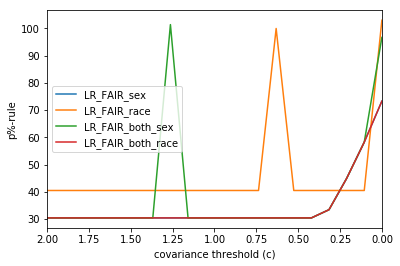

In [174]:
plt.plot(thresh, LR_FAIR_sex_P, label='LR_FAIR_sex')
plt.plot(thresh, LR_FAIR_race_P, label='LR_FAIR_race')
plt.plot(thresh, LR_FAIR_both_Psex, label='LR_FAIR_both_sex')
plt.plot(thresh, LR_FAIR_sex_P, label='LR_FAIR_both_race')
plt.xlim(np.max(thresh), np.min(thresh))
plt.legend()
plt.xlabel('covariance threshold (c)')
plt.ylabel('p%-rule')

plt.show()